In [42]:
# TODO: Make a proper cleaning phase before tokenizing
# TODO: Vizualize the insights of the data we get along the way
# TODO: For Alin, check collaborative ways to use Jupyter Notebook
#       https://cocalc.com/doc/jupyter-notebook.html

import pandas as pd
import numpy as np
import string

In [80]:
# Load training dataset
data = pd.read_csv('train.csv')

In [81]:
# Preview data
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


# Data Cleaning

### Steps to do:
-  ~~Use ID as index ~~
- Spaces (keywords having %20 instead of ' ')
- Unknown characters (try to parse unicode characters properly)
- Lowercase everything
- Links (possibly a feature, check later)
- Punctuation
- Stop words
- Spelling errors
- Stemming and lemmatization
- Locations (we need to filter them and find real cities, and replace the initial value with the found value, otherwise get rid of location)
- Tokenizing

In [82]:
# Use id column as index
data.set_index('id', inplace=True)

In [84]:
# Replace %20 with spaces
data['keyword'].apply(lambda x: x.replace('%20', ' ') if x is not None else '')

AttributeError: 'float' object has no attribute 'replace'

In [48]:
# Loading in nltk and preparing the Stemmer and stopwords/punctuation
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import EnglishStemmer
import nltk
nltk.download("stopwords")
nltk.download('punkt')
stemmer = EnglishStemmer()
stop_words = set(stopwords.words('english')) 

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/hassanalinali/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/hassanalinali/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [59]:
# Tokenizing the sentences and making a list of all texts, keywords and locations

list_sentence = []
for i in range(len(data['text'])):
    token = word_tokenize(data['text'].iloc[i])
    list_sentence.append(token)
list_keywords = ((data['keyword'].value_counts()).reset_index())['index']
list_location = ((data['location'].value_counts()).reset_index())['index']
list_keywords = list(list_keywords)
list_location = list(list_location)
for i in range(len(list_keywords)):
    list_keywords[i] = list_keywords[i].replace('%20', ' ')

In [64]:
# Examine only keywords for disaster tweets:
# TODO: change keywords1 to a proper variable

keywords1 = data[data['target'] == 1]['keyword'].value_counts().reset_index()['index']
keywords1 = list(keywords1)

# TODO: check for other formatting issues in the cleaning phase, not after
for i in range(len(keywords1)):
    keywords1[i] = keywords1[i].replace('%20', ' ')

In [71]:
# Making a counting list of disaster words per sentence
# TODO: Store the keyword found to check for duplicates and modify the count accordingly

list_count = []
for i in range(len(list_sentence)):
    sentence = list_sentence[i]
#     print(sentence)
    count = 0
    for j in range(len(sentence)):
        for k in range(len(keywords1)):
            # If the keyword was in the sentence
            if sentence[j].casefold() == keywords1[k].casefold() and len(keywords1[k].split()) == 1:
                count = count + 1
#                 print(keywords1[k])
            # If the keyword was part of a compound word/expression
            elif len(keywords1[k].split()) == 2: #split words
                if sentence[j].casefold() == keywords1[k].split()[0].casefold() and j+1 < len(sentence):
                    if sentence[j+1].casefold() == keywords1[k].split()[1].casefold():
                        count = count + 1
#                         print("Compound: " + keywords1[k] + " - Split: " + keywords1[k].split()[1])
    list_count.append(count)
#     print()
data['keyword_count'] = list_count

In [72]:
# Check if there is a correlation between the disaster tweets 
# and the amount of disaster keywords used in the sentence

data['target'].corr(data['keyword_count'])

0.2894056208105819

In [73]:
# Make a feature out of hashtags
# TODO: Discuss

#cannot add punctuation or spaces to twitter hashtags
list_hashtags = []
for i in range(len(list_sentence)):
    sentence = list_sentence[i]
    list_pertweet = []
    for j in range(len(sentence)):
        if sentence[j] == '#' and j+1 < len(sentence):
            list_pertweet.append(sentence[j+1])
    if len(list_pertweet) > 0:
        list_hashtags.append(list_pertweet)
    else:
        list_hashtags.append(np.nan)
data['hashtags'] = list_hashtags

In [13]:
location1 = data[data['target'] == 1]['location'].value_counts().reset_index()['index']
list(location1)
location_tok = []
for i in range(len(location1)):
    token = word_tokenize(location1[i])
    token = list(filter(lambda token: token not in string.punctuation, token))
    location_tok.append(token)
#clean location for further processing
#lowercase letter
for i in range(len(location_tok)):
    filtered_sentence = [w for w in location_tok[i] if not w in stop_words]
    for j in range(len(filtered_sentence)):
        filtered_sentence[j] = filtered_sentence[j].casefold()
    location_tok[i] = filtered_sentence

In [14]:
#does having a hashtag affect disaster status
data['hashtags_bool'] = pd.notnull(data['hashtags'])
data['target'].corr(data['hashtags_bool'])

0.07414225496523098

In [15]:
#location and keyword in hashtag
set_location = set()
set_keywords = set()
list_count = []
for i in range(len(location_tok)):
    set_location = set_location.union(set(location_tok[i]))
set_keywords = set(keywords1)
for i in range(len(data['hashtags'])):
    hashtags = data['hashtags'].iloc[i]
    if hashtags != hashtags:
        list_count.append(0)
    else:
        for j in range(len(hashtags)):
            hashtags[j] = hashtags[j].casefold()
        union_l = set(hashtags).intersection(set_location)
        union_k = set(hashtags).intersection(set_keywords)
        list_count.append(len(union_l) + len(union_k))
data['hashtags_count'] = list_count

In [16]:
data['target'].corr(data['hashtags_count'])

0.11169258276380911

In [17]:
#repeating methodology with text
list_count = []
sentence_t = []
for i in range(len(list_sentence)):
    sentence = list_sentence[i]
    for j in range(len(sentence)):
        sentence_t.append(sentence[j].casefold())
    union_l = set(sentence).intersection(set_location)
    union_k = set(sentence).intersection(set_keywords)
    list_count.append(len(union_l) + len(union_k))
data['text_count'] = list_count

In [18]:
data['target'].corr(data['text_count'])

0.056578539919026394

In [21]:
#sentiment analysis
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [22]:
list_score = []
analyzer = SentimentIntensityAnalyzer()
for i in range(len(data['text'])):
    score = analyzer.polarity_scores(data['text'].iloc[i])
    list_score.append(score)

In [23]:
#list_score[0]['neg']
list_neg = []
list_neu = []
list_pos = []
list_compound = []
for i in range(len(list_score)):
    list_neg.append(list_score[i]['neg'])
    list_neu.append(list_score[i]['neu'])
    list_pos.append(list_score[i]['pos'])
    list_compound.append(list_score[i]['compound'])
data['neg'] = list_neg
data['neu'] = list_neu
data['pos'] = list_pos
data['compound'] = list_compound

In [24]:
data['target'].corr(data['neg']) #0.1298389384419161
data['target'].corr(data['neu']) #0.02670054925813727
data['target'].corr(data['pos']) #-0.20805222028816894
data['target'].corr(data['compound']) #-0.22776956071990492

-0.22032820261759334

In [26]:
import seaborn as sn

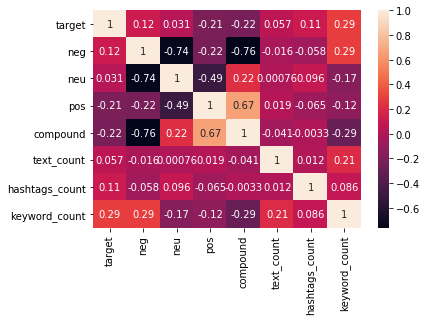

In [27]:
#correlation matrix
data_corr = data[['target', 'neg', 'neu', 'pos', 'compound', 'text_count', 'hashtags_count', 'keyword_count']]
corrMatrix = data_corr.corr()
sn.heatmap(corrMatrix, annot=True)

In [28]:
sentence_1  = data[data['target'] == 1]['text'] 
list_sentence1 = []
for i in range(len(sentence_1)):
    token = word_tokenize(sentence_1.iloc[i])
    list_sentence1.append(token)

In [29]:
#Feature: @user
list_user = []
for i in range(len(list_sentence1)):
    sentence = list_sentence1[i]
    for i in range(len(sentence)):
        if sentence[i] == '@' and i+1 < len(sentence):
            list_user.append(sentence[i+1])
list_user = list(set(list_user))

In [30]:
list_countuser = []
for i in range(len(list_sentence)):
    sentence = list_sentence[i]
    count = 0
    for j in range(len(sentence)):
        if sentence[j] == '@' and j+1 < len(sentence):
            for k in range(len(list_sentence1)):
                sentence1 = list_sentence1[k]
                for m in range(len(sentence1)):
                    if sentence[j+1].casefold() == sentence1[m].casefold():
                        count = count + 1
    list_countuser.append(count)
data['count_user'] = list_countuser

In [31]:
data['target'].corr(data['count_user'])

-0.013848793230842447

In [35]:
#Bag of Words Model
#https://medium.com/data-from-the-trenches/text-classification-the-first-step-toward-nlp-mastery-f5f95d525d73
from sklearn.feature_extraction.text import CountVectorizer

In [36]:
vectorizer = CountVectorizer(
    stop_words="english",
)
#upper and lower case in text??? multiple languages??? weird format????

In [37]:
sentences = []
for i in range(len(list_sentence)):
    sentence = list_sentence[i]
    for j in range(len(sentence)):
        sentences.append(sentence[j])
#fit vectorizer on the training text
text_counts = vectorizer.fit_transform(sentences)
# get the vectorizer's vocabulary
inv_vocab = {v: k for k, v in vectorizer.vocabulary_.items()}
vocabulary = [inv_vocab[i] for i in range(len(inv_vocab))]

In [38]:
#TF-IDF
#https://github.com/javedsha/text-classification/blob/master/Text%2BClassification%2Busing%2Bpython%2C%2Bscikit%2Band%2Bnltk.ipynb
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()
text_tfidf = tfidf_transformer.fit_transform(text_counts)

In [39]:
#Example:
#https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
example = ['I', 'am', 'an', 'example']
result_count = vectorizer.transform(example).toarray()
result_count.shape
#Take the count vector and transform to TF-IDF
result_tfidf = tfidf_transformer.transform(result_count)
result_tfidf.shape 

(4, 21355)

In [40]:
#N-gram
from nltk import bigrams

In [41]:
list_bigrams = []
for i in range(len(list_sentence)):
    string_bigrams = bigrams(list_sentence[i])
    list_bigrams.append(string_bigrams)